# **GAN**

In [ ]:
!nvidia-smi

In [1]:
import numpy as np
from keras.layers import BatchNormalization, Activation, Embedding, multiply
from keras.layers import Input, Dense, Reshape, Flatten, Concatenate
from keras.models import Model, Sequential
import tensorflow as tf
import os
import time
from matplotlib import pyplot as plt
from IPython import display
import h5py
from tqdm import tqdm
from sklearn.model_selection import train_test_split

## **Mounting_Google_Drive** 

In [2]:
from google.colab import drive
#drive.flush_and_unmount()
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## **Importing_Data**

In [2]:
def load_data(CATEGORY = 'CAR' , MAX_MODELS=1) :
  t0= time.clock()

  '''
  docs

  ex : (x_train,y_train) , (x_test,y_test) = load_data(CATEGORY='CAR' , MAX_MODELS=100)

  CATEGORY specifies the category of model (CAR , AEROPLANE) we are using, MAX_MODELS specifies the maximum number of models we will be taking
  MAX_MODELS should be always less than 3000
  one model will have 576 records
  '''

  path = "/content/gdrive/My Drive/dataset/ShapenetRendering_{}.h5".format(CATEGORY)
  model_name = "/content/gdrive/My Drive/dataset/model_names_{}.txt".format(CATEGORY)

  x_img = []
  y = []
  params1=[]
  params2=[]

  file1 = open(model_name , 'r')

  with h5py.File(path , 'r') as hdf :
    keys = list(hdf.keys())

    counter = 0

    Lines = file1.readlines()

    for line in Lines :
      n = line.strip()
      for i in range(24) :
        i_name = "{}_{}".format(n,i)
        img_x=np.array(hdf[i_name].get('image'))
        pose_x=np.array(hdf[i_name].get('pose'))

        for j in range(24) :
          j_name = "{}_{}".format(n,j)

          img_y = np.array(hdf[j_name].get('image'))
          pose_y=np.array(hdf[j_name].get('pose'))

          par=pose_y-pose_x
          param1=np.full((256,256,4),par[0])
          param2=np.full((256,256,4),par[1])

          params1.append(param1)
          params2.append(param2)
          x_img.append(img_x)
          y.append(img_y)

      counter += 1

      if counter >= MAX_MODELS or counter >= 3000 :
        break

  x_img = np.array(x_img)
  y = np.array(y)
  params1=np.array(params1)
  params2=np.array(params2)

  train_images, test_images, train_params1, test_params1, train_params2, test_params2, train_real_op,test_real_op= train_test_split(x_img, params1, params2, y, test_size=0.2, random_state=42)
  
  t1 = time.clock() - t0

  t1 = round(t1 , 3)
  print("Time elapsed: ", t1 , 'seconds')

  return (train_images, train_params1, train_params2, train_real_op),(test_images, test_params1, test_params2, test_real_op)

In [3]:
(train_images, train_params1, train_params2, train_real_op),(test_images, test_params1, test_params2, test_real_op) = load_data(MAX_MODELS=3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


Time elapsed:  11.252 seconds


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [9]:
train_images = tf.image.resize(train_images, [256, 256], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
train_images = tf.cast(train_images, tf.float32)
train_images = (train_images- 127.5) / 127.5
train_real_op = tf.image.resize(train_real_op, [256, 256], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
train_real_op = tf.cast(train_real_op, tf.float32)
train_real_op = (train_real_op-127.5)/127.5

test_images = tf.image.resize(test_images, [256, 256], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
test_images = tf.cast(test_images, tf.float32)
test_images = (test_images- 127.5) / 127.5
test_real_op = tf.image.resize(test_real_op, [256, 256], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
test_real_op = tf.cast(test_real_op, tf.float32)
test_real_op = (test_real_op-127.5)/127.5

In [10]:
BUFFER_SIZE = train_images.shape[0]
BATCH_SIZE = 2
train_dataset = tf.data.Dataset.from_tensor_slices((train_images,train_params1,train_params2,train_real_op)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

BUFFER_SIZE1 = test_images.shape[0]
BATCH_SIZE1 = 2

test_dataset = tf.data.Dataset.from_tensor_slices((test_images,test_params1,test_params2,test_real_op)).shuffle(BUFFER_SIZE1).batch(BATCH_SIZE1)

In [11]:
OUTPUT_CHANNELS = 4

# **Generator**

In [12]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [13]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [14]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 4],dtype='float32')
  param1=tf.keras.layers.Input(shape=[256, 256, 4],dtype='float32')
  param2=tf.keras.layers.Input(shape=[256, 256, 4],dtype='float32')

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (bs, 128, 128, 64)
    downsample(128, 4),  # (bs, 64, 64, 128)
    downsample(256, 4),  # (bs, 32, 32, 256)
    downsample(512, 4),  # (bs, 16, 16, 512)
    downsample(512, 4),  # (bs, 8, 8, 512)
    downsample(512, 4),  # (bs, 4, 4, 512)
    downsample(512, 4),  # (bs, 2, 2, 512)
    downsample(512, 4),  # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (bs, 8, 8, 1024)
    upsample(512, 4),  # (bs, 16, 16, 1024)
    upsample(256, 4),  # (bs, 32, 32, 512)
    upsample(128, 4),  # (bs, 64, 64, 256)
    upsample(64, 4),  # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (bs, 256, 256, 3)
  x = inputs
  x=tf.keras.layers.Concatenate(axis=-1)([x, param1])
  x=tf.keras.layers.Concatenate(axis=-1)([x, param2])

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)
  return tf.keras.Model(inputs=[inputs,param1,param2], outputs=x)

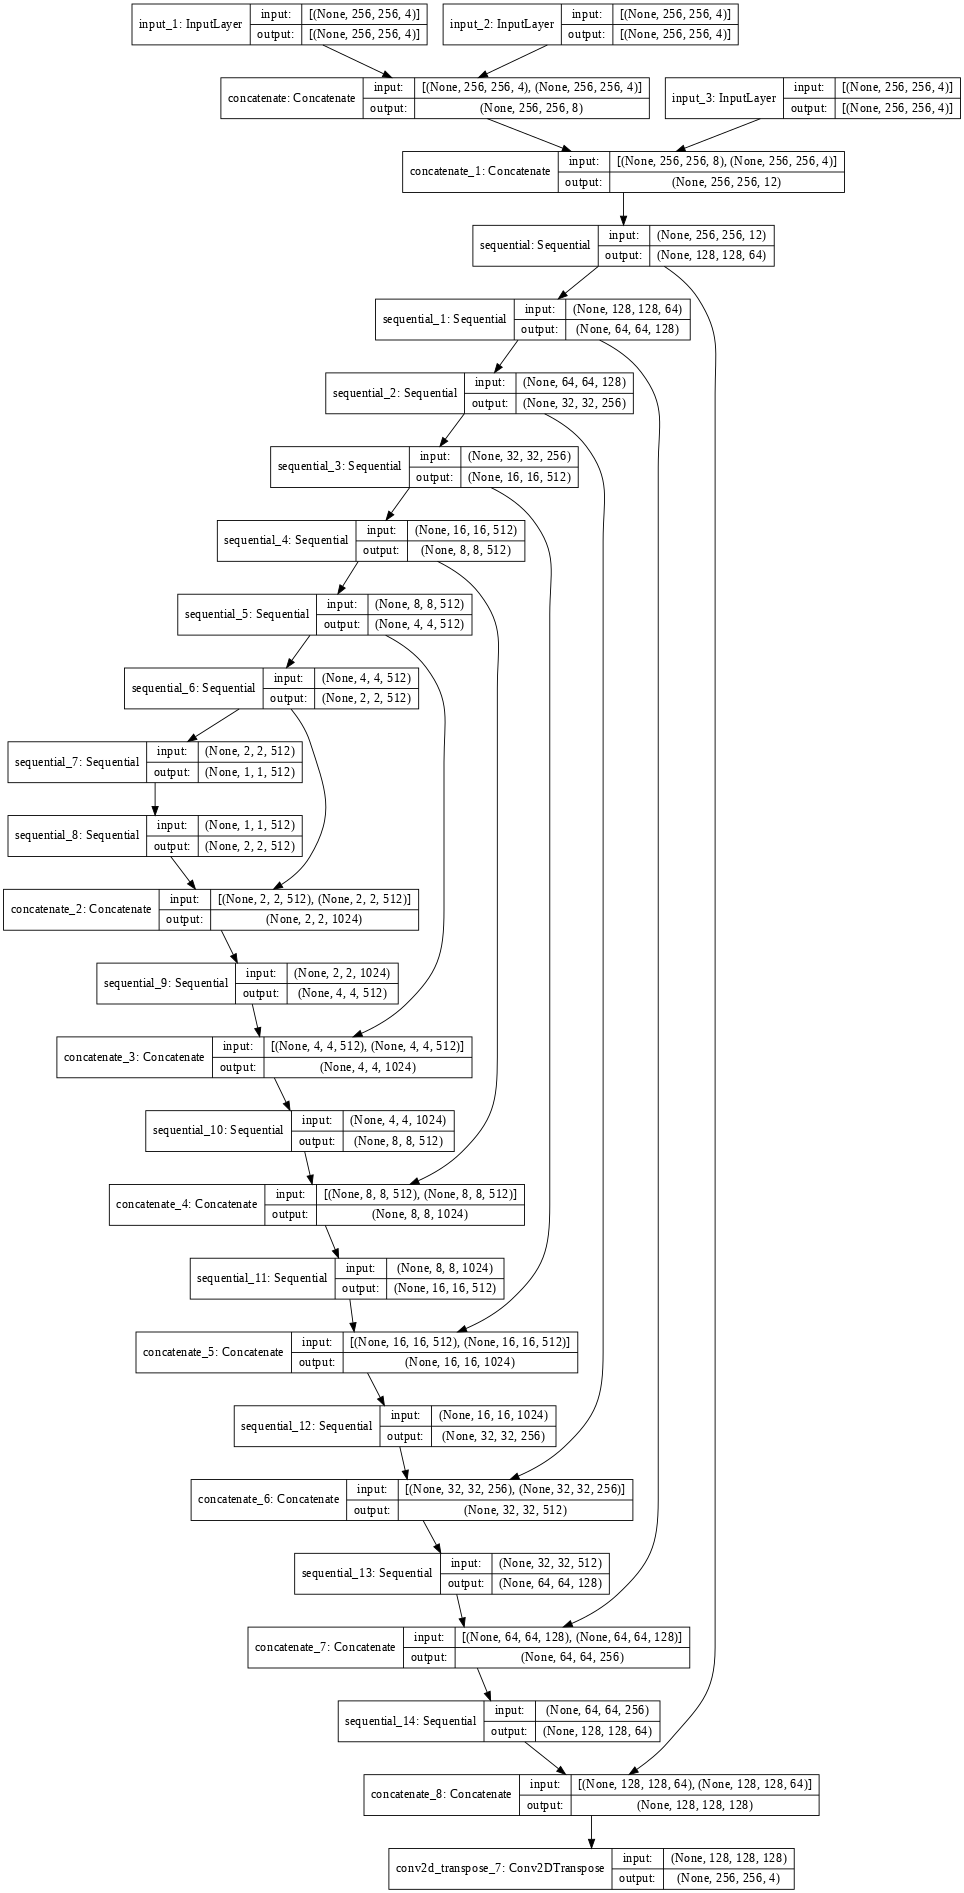

In [15]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

In [16]:
LAMBDA = 100

In [17]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [18]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

# **Discriminator**

In [19]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 4], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 4], name='target_image')
  param1= tf.keras.layers.Input(shape=[256, 256, 4], name='param1')
  param2= tf.keras.layers.Input(shape=[256, 256, 4], name='param2')

  x = tf.keras.layers.concatenate([inp, tar])  # (bs, 256, 256, channels*2)
  x = tf.keras.layers.concatenate([x, param1])
  x = tf.keras.layers.concatenate([x, param2])

  down1 = downsample(64, 4, False)(x)  # (bs, 128, 128, 64)
  down2 = downsample(128, 4, False)(down1)  # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar,param1,param2], outputs=last)

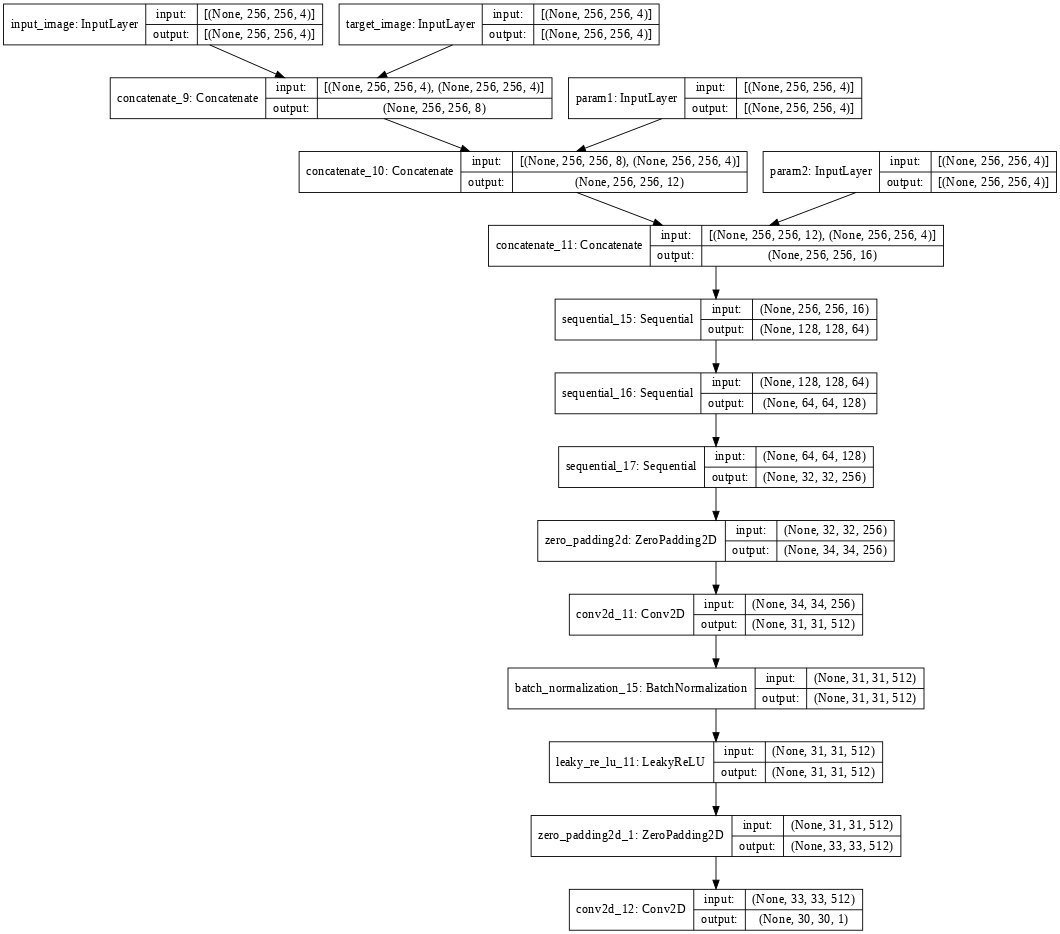

In [20]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [21]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

## **Optimizers**

In [22]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# **Checkpoint**

In [23]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# **Generate_Images**

In [24]:
def generate_images(model, test_input, param1, param2, tar):
  prediction = model([test_input,param1, param2], training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Target Image', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [25]:
def generate_req_images(model, test_input, param1, param2, tar):
  prediction = model([test_input,param1, param2], training=True)
  plt.figure(figsize=(15, 15))
  deg=param1.numpy()[0][0][0][0]
  head='Predicted Image('+ str(deg) +')'
  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', head]

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

# **Training**

In [39]:
EPOCHS = 100

In [27]:
import datetime
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [28]:
@tf.function
def train_step(input_image, param1, param2, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator([input_image, param1, param2], training=True)

    disc_real_output = discriminator([input_image, target, param1, param2], training=True)
    disc_generated_output = discriminator([input_image, gen_output, param1, param2], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
    tf.summary.scalar('disc_loss', disc_loss, step=epoch)

In [29]:
def fit(train_ds, epochs, test_ds):
  for epoch in range(epochs):
    start = time.time()

    display.clear_output(wait=True)

    for example_input, example_param1, example_param2, example_target in test_ds.take(2):
      generate_images(generator, example_input, example_param1, example_param2, example_target)
    print("Epoch: ", epoch)

    # Train
    for n, (input_image, param1, param2, target) in train_ds.enumerate():
      print('.', end='')
      if (n+1) % 100 == 0:
        print()
      train_step(input_image, param1, param2, target, epoch)
    print()

    # saving (checkpoint) the model every 20 epochs
    if (epoch + 1) % 20 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
  checkpoint.save(file_prefix=checkpoint_prefix)

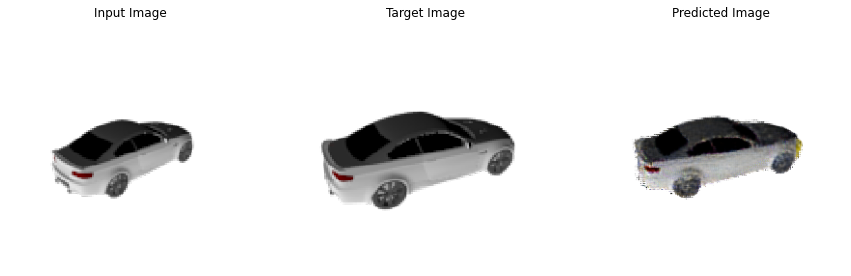

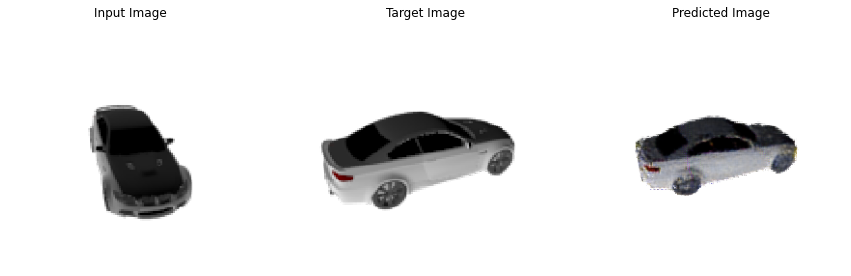

Epoch:  99
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
...........................................................................................
Time taken for epoch 100 is 64.05395603179932 sec



In [41]:
fit(train_dataset, EPOCHS, test_dataset)

## **Restore_checkpoint**

In [ ]:
!ls {checkpoint_dir}

In [40]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## **Restore_Checkpoint_from_Drive**

In [33]:
checkpoint.restore(tf.train.latest_checkpoint('/content/gdrive/MyDrive/GAN_models/Gan_car_ckpt4/'))

## **Saving_Checkpoint_to_Drive**

In [71]:
!cp -r /content/training_checkpoints/ckpt-9.data-00000-of-00001 /content/gdrive/MyDrive/GAN_models/Gan_car_ckpt4/

# **Testing**

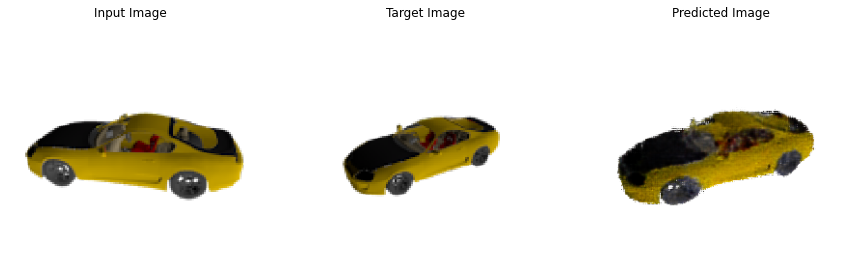

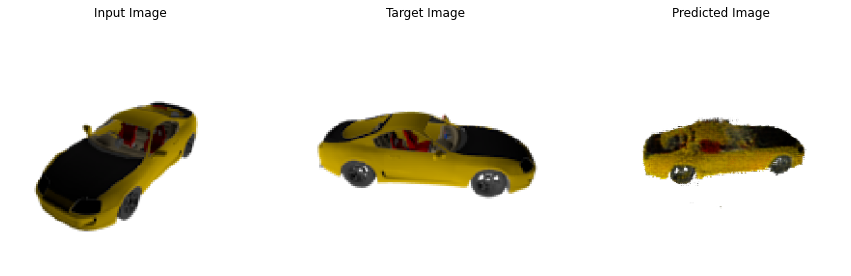

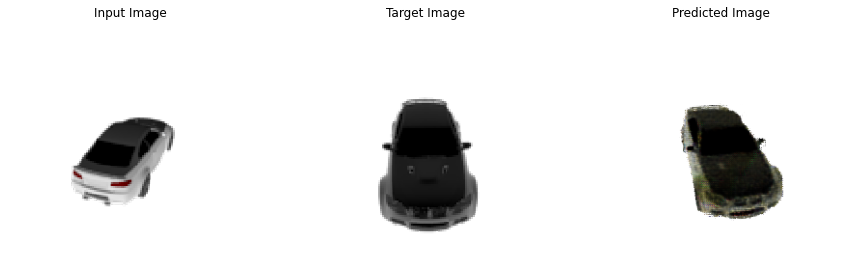

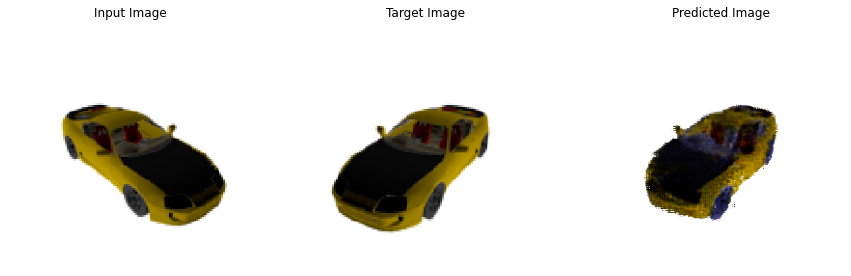

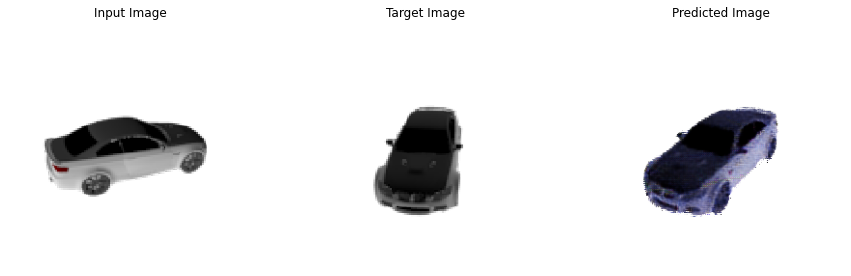

In [43]:
for inp, param1, param2, tar in test_dataset.take(5):
  generate_images(generator, inp, param1, param2, tar)

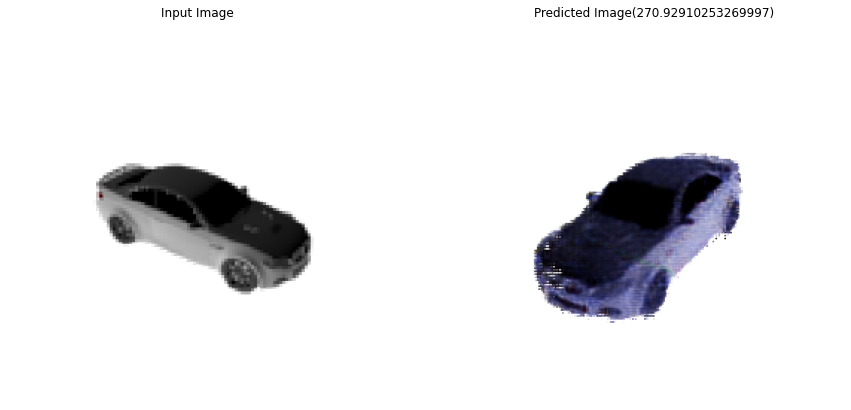

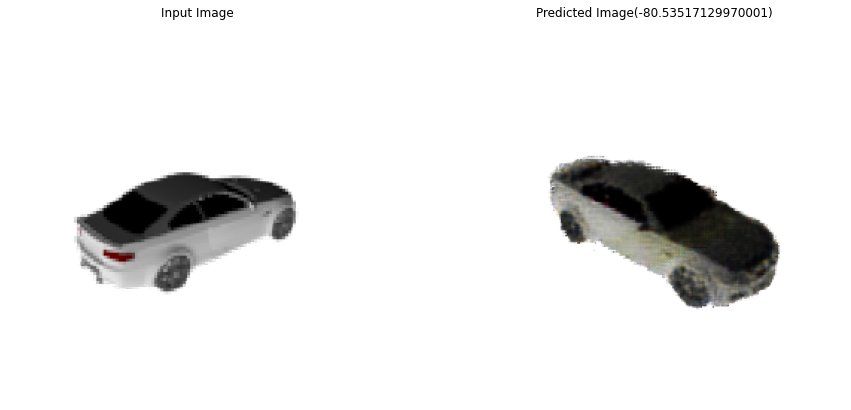

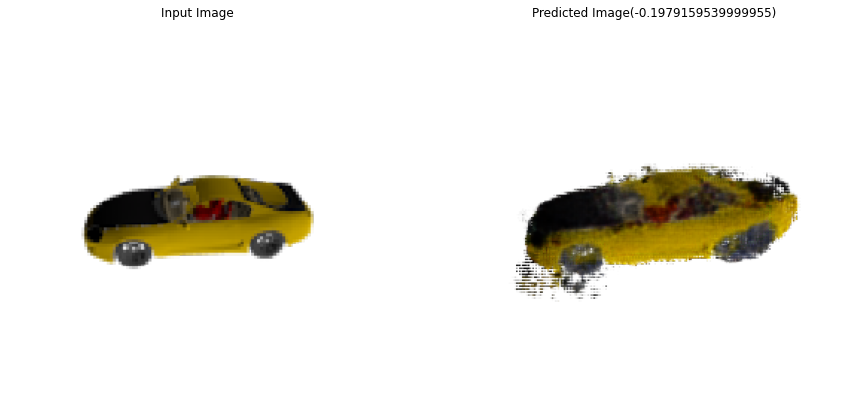

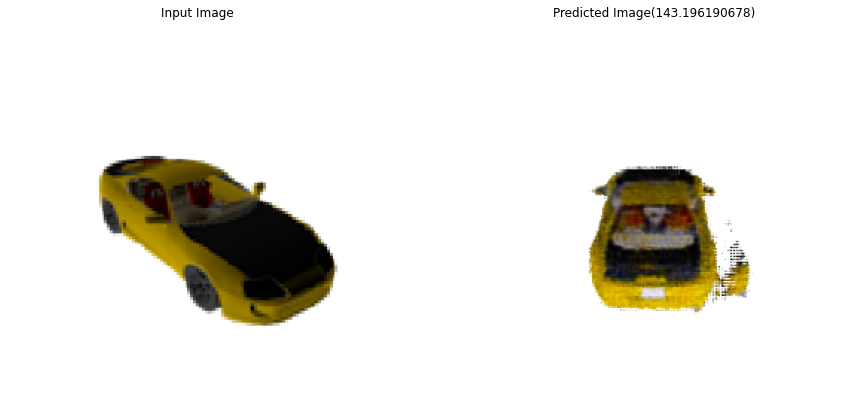

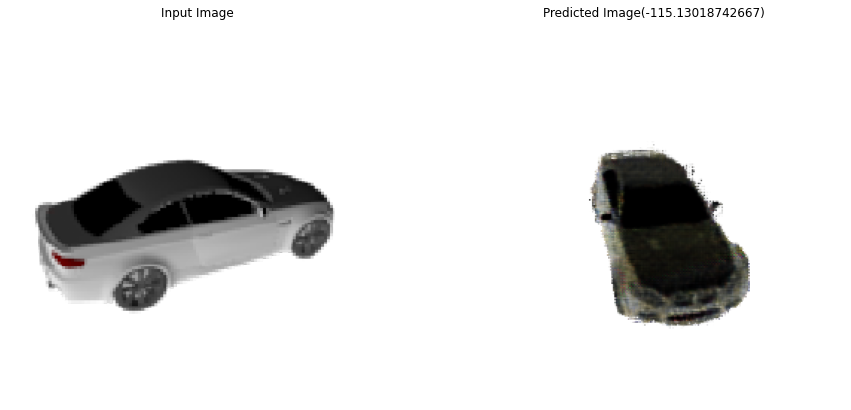

In [46]:
for inp, param1, param2, tar in test_dataset.take(5):
  generate_req_images(generator, inp, param1, param2, tar)

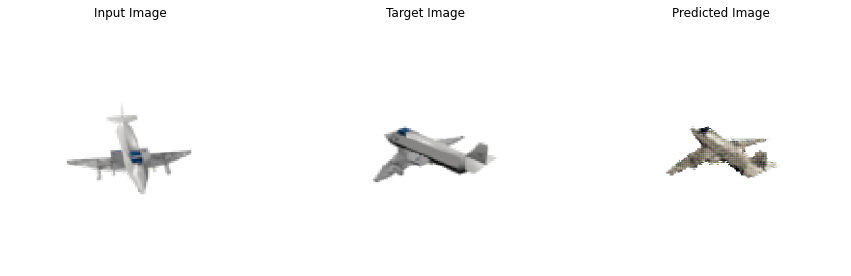

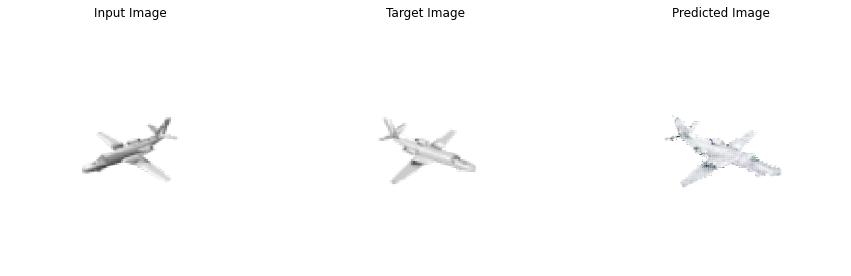

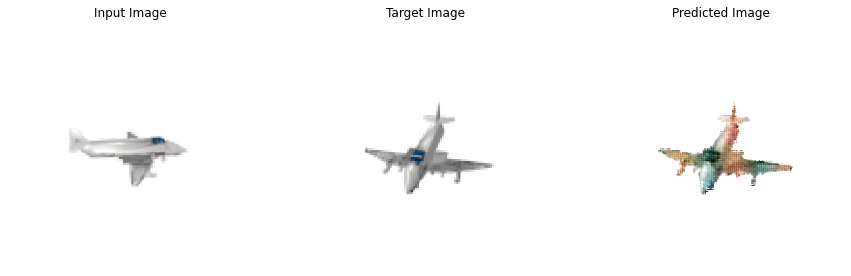

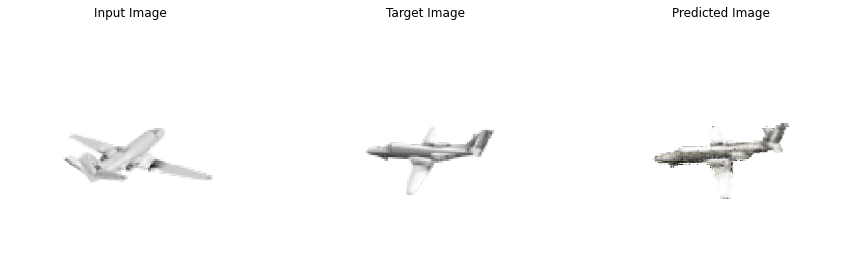

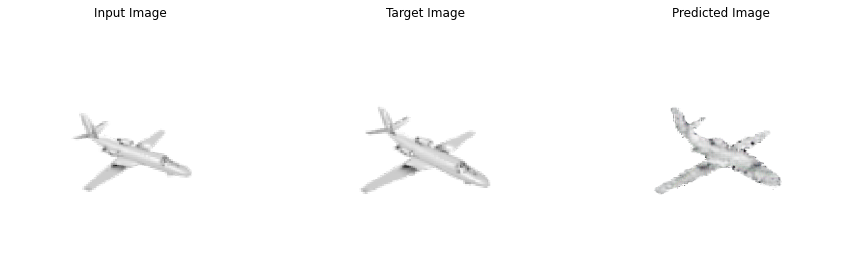

In [ ]:
for inp, param1, param2, tar in test_dataset.take(5):
  generate_images(generator, inp, param1, param2, tar)

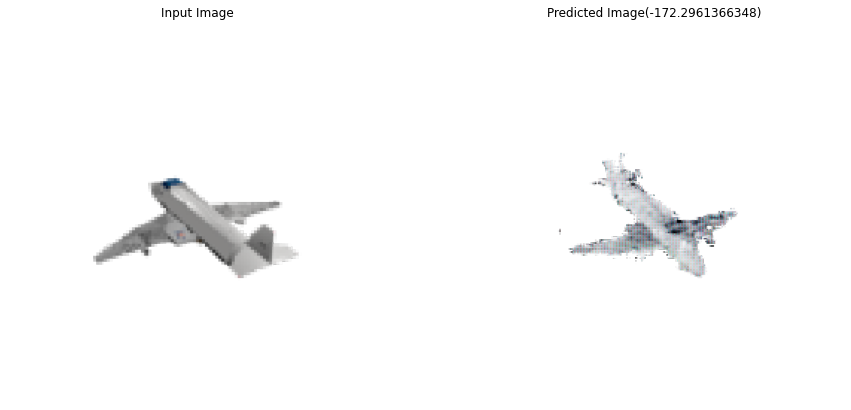

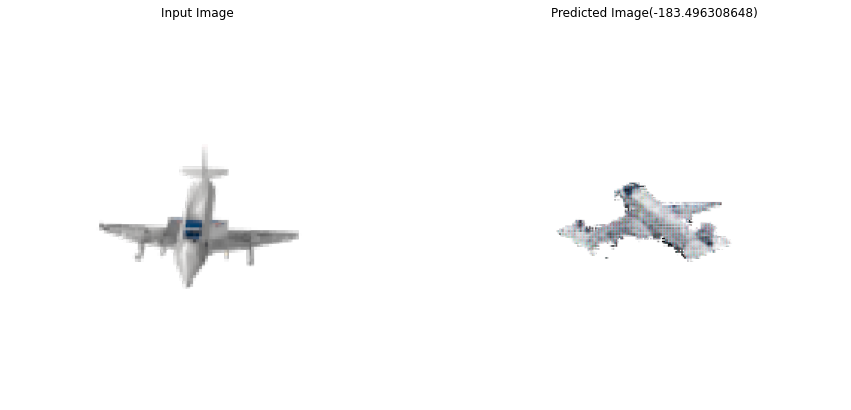

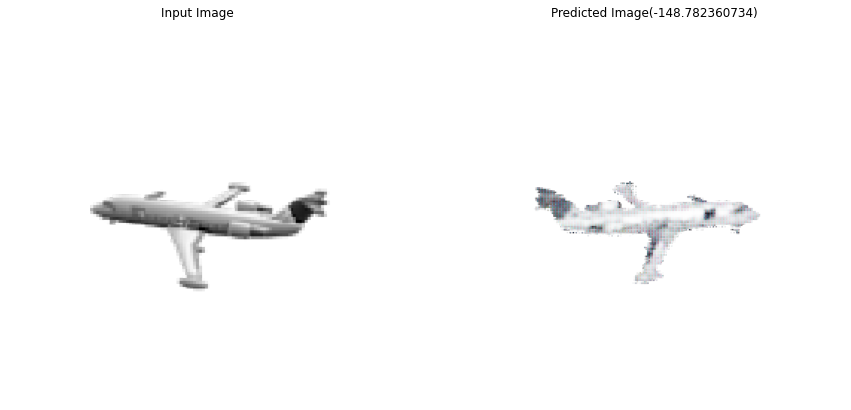

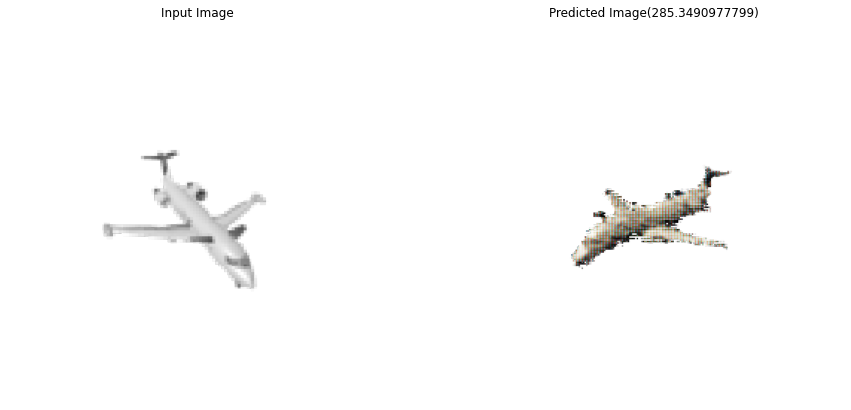

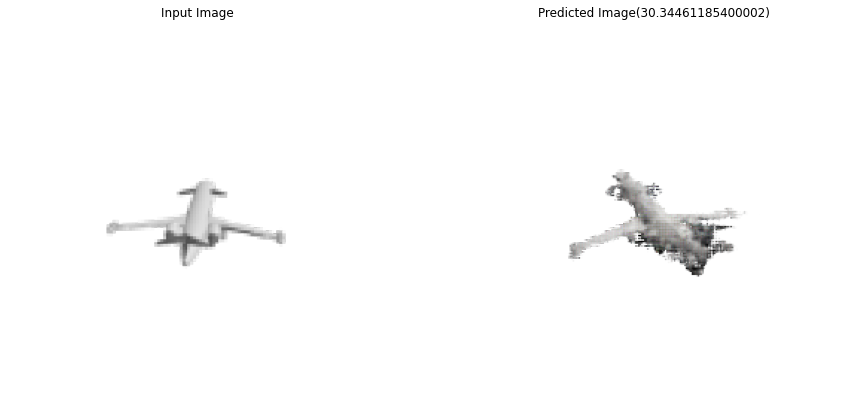

In [ ]:
for inp, param1, param2, tar in test_dataset.take(5):
  generate_req_images(generator, inp, param1, param2, tar)

-47.8545127214
-1.3107558498000031


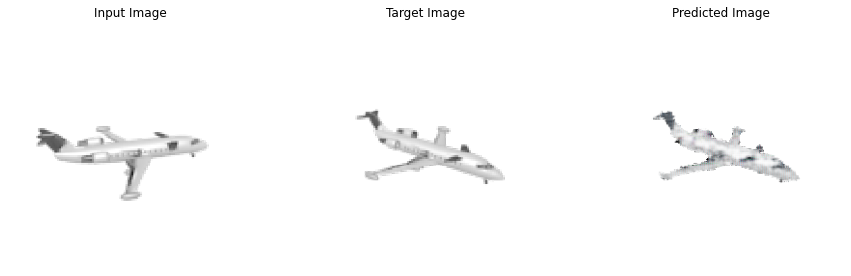

In [ ]:
samp_inp=tf.reshape(train_images[1001],[1,256,256,4])
samp_tar=tf.reshape(train_real_op[1001],[1,256,256,4])
print(train_params1[1001][0][0][0])
print(train_params2[1001][0][0][0])
samp_param1=tf.fill([1,256,256,4], -47.8)
samp_param2=tf.fill([1,256,256,4], -1.3)
#samp_param1=tf.reshape(test_params1[449],[1,256,256,1])
#samp_param2=tf.reshape(test_params2[449],[1,256,256,1])
generate_images(generator, samp_inp, samp_param1, samp_param2, samp_tar)

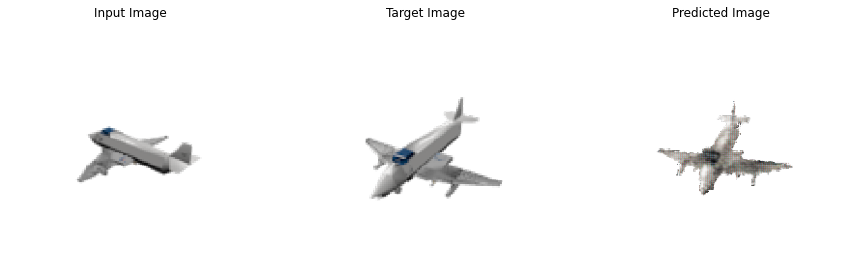

In [ ]:
samp_inp=tf.reshape(test_images[225],[1,256,256,4])
samp_tar=tf.reshape(test_real_op[225],[1,256,256,4])
samp_param1=tf.reshape(test_params1[225],[1,256,256,1])
samp_param2=tf.reshape(test_params2[225],[1,256,256,1])
generate_images(generator, samp_inp, samp_param1, samp_param2, samp_tar)

